In [51]:
import numpy as np
import yfinance as yf
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt
from scipy.optimize import minimize   


In [123]:
tickers = ['VTI', 'AGG', 'DBC', '^VIX']
data = yf.download(tickers, start="2012-01-01", end="2020-12-31", interval="1d")['Adj Close']
data_na = data.dropna(axis = 0)
for column in data_na.columns:
    data_na[f'{column}_R'] = data_na[f'{column}'].pct_change()
    data_na[f'{column}_y'] = data_na[f'{column}_R'].shift(-1)
data_na.dropna(axis=0, inplace=True)
data_na.reset_index(inplace=True)
data_na['Date'] = data_na['Date'].dt.date


[*********************100%***********************]  4 of 4 completed


In [124]:
data = data_na[['AGG', 'DBC', 'VTI', '^VIX']]
data

Ticker,AGG,DBC,VTI,^VIX
0,79.343895,25.637207,51.931351,22.219999
1,79.452194,25.287399,52.162197,21.480000
2,79.517212,25.397865,52.042786,20.629999
3,79.452194,25.425482,52.162197,21.070000
4,79.430504,25.609591,52.679600,20.690001
...,...,...,...,...
2257,106.759209,13.624198,181.857025,24.230000
2258,106.686783,13.794738,182.168045,23.309999
2259,106.786354,13.832635,182.472778,21.530001
2260,106.804443,13.747366,183.627335,21.700001


In [125]:
# Paramètres
volatility_target = 0.10  # Target de volatilité
cost_rate = 0.01 
window = 50  # Période de calcul des rendements (fenêtre de 50 jours)
risk_free_rate = 0.0  # Taux sans risque pour le calcul du Sharpe ratio



In [126]:
# rendements quotidiens
returns = data.pct_change().dropna()
rolling_returns = returns.rolling(window=window).mean().dropna()

# volatilité ex-ante avec une fenêtre mobile de 50 jours
volatility = returns.rolling(window=window).std().dropna()

# rendements moyens et la matrice de covariance
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

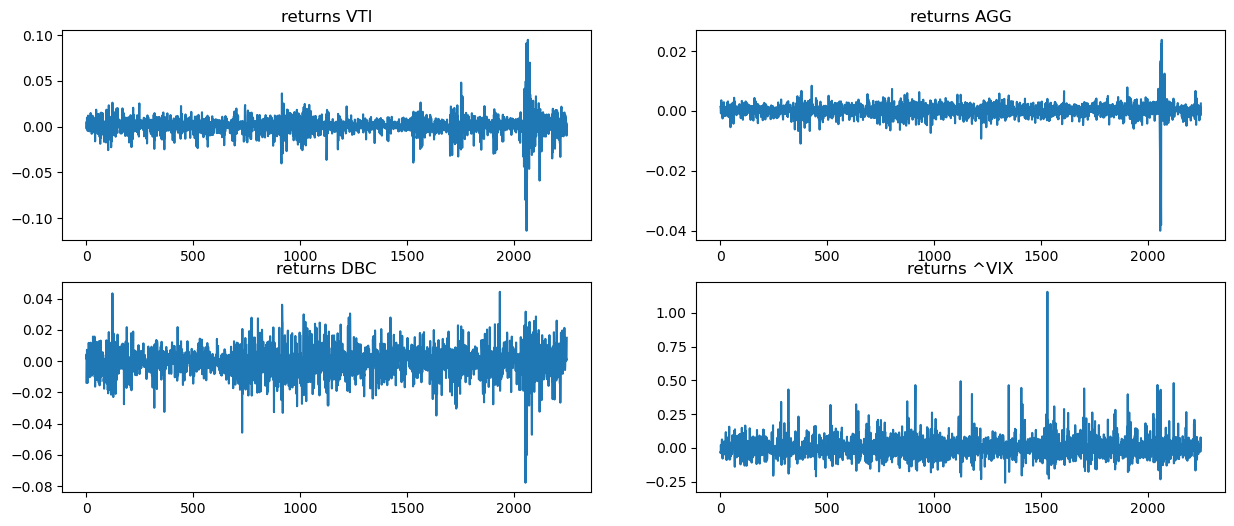

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))

axes = axes.flatten()

for i, ticker in enumerate(tickers):
    axes[i].plot(returns[ticker].values)
    axes[i].set_title(f"returns {ticker}")
plt.show()


In [101]:
volatility

Ticker,AGG,DBC,VTI,^VIX
50,0.001761,0.007322,0.006314,0.053886
51,0.001806,0.007015,0.006310,0.054146
52,0.001815,0.007262,0.006328,0.054233
53,0.001845,0.007279,0.006344,0.054216
54,0.001850,0.007332,0.006395,0.054397
...,...,...,...,...
2245,0.001952,0.009879,0.011371,0.060919
2246,0.001963,0.009879,0.011230,0.060198
2247,0.001959,0.009830,0.011012,0.060312
2248,0.001970,0.009650,0.011092,0.061358


In [102]:
rolling_returns

Ticker,AGG,DBC,VTI,^VIX
50,-0.000008,0.001232,0.002121,-0.007131
51,-0.000100,0.001471,0.002107,-0.005677
52,-0.000087,0.001140,0.002084,-0.004168
53,-0.000023,0.001070,0.002016,-0.005172
54,0.000001,0.000768,0.001657,-0.004229
...,...,...,...,...
2245,0.000019,0.001665,0.003131,-0.004518
2246,0.000043,0.001665,0.002787,-0.002533
2247,0.000027,0.001524,0.002511,-0.002971
2248,-0.000005,0.001768,0.002426,-0.001494


## Version classique

In [103]:
def portfolio_performance(weights, mean_returns, cov_matrix):

    """
    computes the mean and the vol of the portfolio returns 
    """
    portfolio_rets = np.dot(weights, mean_returns)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_rets, portfolio_vol

def portfolio_variance(weights, mean_returns, cov_matrix):
    """
    defines the objective function for the optimization problem
    """
    return portfolio_performance(weights, mean_returns, cov_matrix)[1] ** 2


In [40]:
# Les poids doivent somme à 1 (sum(weights) = 1)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# Les poids sont compris entre 0 et 1 (long-only)
bounds = tuple((0, 1) for _ in range(len(mean_returns)))


In [61]:
# Optimizing the portfolio 
num_assets = len(mean_returns)

initial_guess = num_assets * [1 / num_assets]
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

optimized_result = minimize(portfolio_variance,
                            initial_guess,
                            args=(mean_returns, cov_matrix),
                            method='SLSQP',
                            bounds=bounds,
                            constraints=constraints)


In [62]:
optimal_weights = optimized_result.x
optimal_return, optimal_volatility = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

print("Optimal Weights:", optimal_weights)
print("Expected Annual Return:", optimal_return)
print("Annual Volatility:", optimal_volatility)


Optimal Weights: [0.8669688  0.03859311 0.08666302 0.00777508]
Expected Annual Return: 0.04690746752369318
Annual Volatility: 0.0376412275765658


# Version maximisation du sharpe ratio

In [127]:
# calculer le ratio de Sharpe
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return (portfolio_return - risk_free_rate) / portfolio_volatility

# l'optimisation du ratio de Sharpe (on minimise -Sharpe)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    return -sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate)


In [128]:
# 6. Trouver les poids optimaux qui maximisent le ratio de Sharpe
initial_weights = len(mean_returns) * [1. / len(mean_returns)]  # Poids initiaux (égaux pour chaque actif)
result = sco.minimize(neg_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix), 
                      method='SLSQP', bounds=bounds, constraints=constraints)

# 7. Afficher les résultats
optimal_weights = result.x
max_sharpe = -result.fun

print("Poids optimaux du portefeuille :", optimal_weights)
print("Ratio de Sharpe maximal :", max_sharpe)


Poids optimaux du portefeuille : [0.47937064 0.         0.46678912 0.05384024]
Ratio de Sharpe maximal : 2.1868190032166828


In [129]:
#Equation 7
def calculate_portfolio_returns(weights_t_minus_1, weights_t_minus_2, returns_t, volatility_t_minus_1, volatility_t_minus_2, volatility_target, cost_rate):
    # Adjust positions with volatility scaling
    scaled_weights_t_minus_1 = (volatility_target / volatility_t_minus_1) * weights_t_minus_1
    scaled_weights_t_minus_2 = (volatility_target / volatility_t_minus_2) * weights_t_minus_2

    # Calculate portfolio return
    portfolio_return = np.sum(scaled_weights_t_minus_1 * returns_t)

    # Calculate transaction costs
    transaction_cost = cost_rate * np.sum(np.abs(scaled_weights_t_minus_1 - scaled_weights_t_minus_2))

    # Final portfolio return after accounting for transaction costs
    portfolio_return_after_costs = portfolio_return - transaction_cost

    return portfolio_return_after_costs


In [130]:
# Stocker les poids optimaux pour chaque jour
optimal_weights_over_time = []

# 5. Optimisation sur une fenêtre de 50 jours, en recalculant les poids chaque jour
for i in range(window, len(returns)):
    # Calculer les rendements moyens et la matrice de covariance sur la fenêtre de 50 jours
    rolling_returns = returns.iloc[i-window:i]  # Fenêtre de 50 jours
    mean_returns = rolling_returns.mean()
    cov_matrix = rolling_returns.cov()
    
    # Nombre d'actifs
    n_assets = len(mean_returns)

    # Poids initiaux égaux (pour n_assets actifs)
    initial_weights = n_assets * [1. / n_assets]
    
    # Mettre à jour les bornes pour n_assets
    bounds = tuple((0, 1) for _ in range(n_assets))  # Les poids sont entre 0 et 1
    
    # Optimisation du ratio de Sharpe
    result = sco.minimize(neg_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Stocker les poids optimaux du jour
    optimal_weights_over_time.append(result.x)


In [131]:
# Convertir les poids optimaux en DataFrame pour visualisation
weights_df = pd.DataFrame(optimal_weights_over_time, columns=data.columns, index=returns.index[window:])
print(weights_df.head())  # Afficher les premiers poids optimaux


Ticker       AGG           DBC       VTI      ^VIX
51      0.487709  1.610556e-02  0.474625  0.021561
52      0.367567  5.597059e-02  0.545476  0.030987
53      0.371451  0.000000e+00  0.591362  0.037187
54      0.465278  0.000000e+00  0.506731  0.027991
55      0.492209  1.105886e-17  0.480983  0.026808


In [132]:
weights_df

Ticker,AGG,DBC,VTI,^VIX
51,0.487709,1.610556e-02,0.474625,0.021561
52,0.367567,5.597059e-02,0.545476,0.030987
53,0.371451,0.000000e+00,0.591362,0.037187
54,0.465278,0.000000e+00,0.506731,0.027991
55,0.492209,1.105886e-17,0.480983,0.026808
...,...,...,...,...
2257,0.382672,2.130929e-01,0.343116,0.061119
2258,0.428353,2.100020e-01,0.307066,0.054578
2259,0.388556,2.487304e-01,0.309179,0.053535
2260,0.407028,2.280970e-01,0.317376,0.047499


In [133]:
portfolio_returns_after_costs=[]

for t in range(2, len(weights_df)):
    # Utiliser les poids de t-1 et t-2
    weights_t_minus_1 = weights_df.iloc[t-1].values
    weights_t_minus_2 = weights_df.iloc[t-2].values
    
    if (window + t - 1 < len(volatility)) and (window + t - 2 < len(volatility)):
        returns_t = returns.iloc[window + t].values
        volatility_t_minus_1 = volatility.iloc[window + t - 1].values
        volatility_t_minus_2 = volatility.iloc[window + t - 2].values
        
        portfolio_return = calculate_portfolio_returns(
            weights_t_minus_1=weights_t_minus_1,
            weights_t_minus_2=weights_t_minus_2,
            returns_t=returns_t,
            volatility_t_minus_1=volatility_t_minus_1,
            volatility_t_minus_2=volatility_t_minus_2,
            volatility_target=volatility_target,
            cost_rate=cost_rate
        )
        
        portfolio_returns_after_costs.append(portfolio_return)

In [134]:
portfolio_returns_after_costs

[np.float64(-0.03621580117123761),
 np.float64(-0.04489711529341166),
 np.float64(0.014235246877175159),
 np.float64(0.03708067895854652),
 np.float64(0.019082204018281257),
 np.float64(-0.0555482283978465),
 np.float64(0.02332315427926522),
 np.float64(-0.038945661009734615),
 np.float64(-0.02000965993274273),
 np.float64(-0.15437360781756987),
 np.float64(-0.002907109728376177),
 np.float64(0.010045993551192824),
 np.float64(0.06459790196058715),
 np.float64(-0.09424507148327972),
 np.float64(0.012101316120104826),
 np.float64(-0.015573627110742672),
 np.float64(-0.013490544007722885),
 np.float64(-0.050875315418994926),
 np.float64(-0.007763175859271304),
 np.float64(0.00785414909078035),
 np.float64(-0.06227619047892201),
 np.float64(-0.02097316194014925),
 np.float64(-0.015940247512929627),
 np.float64(-0.11383141207178783),
 np.float64(0.006108028683934924),
 np.float64(0.08740191650763365),
 np.float64(-0.03328033569982668),
 np.float64(-0.03809678211363119),
 np.float64(-0.0246

In [135]:
# Correction de la longueur de l'index pour correspondre à la taille des rendements ajustés
portfolio_index = returns.index[window + 2: window + 2 + len(portfolio_returns_after_costs)]

# Créer une série avec les rendements ajustés et l'index correspondant
portfolio_returns_after_costs_series = pd.Series(portfolio_returns_after_costs, index=portfolio_index)

print("Rendements ajustés du portefeuille :", portfolio_returns_after_costs_series)


Rendements ajustés du portefeuille : 53     -0.036216
54     -0.044897
55      0.014235
56      0.037081
57      0.019082
          ...   
2209   -0.061700
2210    0.006509
2211   -0.012068
2212   -0.104928
2213    0.028937
Length: 2161, dtype: float64


In [136]:
# 1. Calcul de la moyenne des rendements du portefeuille
portfolio_mean_return = portfolio_returns_after_costs_series.mean()
print(f"Moyenne des rendements du portefeuille : {portfolio_mean_return:.6f}")

# 2. Calcul de la volatilité (écart-type) des rendements du portefeuille
portfolio_volatility = portfolio_returns_after_costs_series.std()
print(f"Volatilité (écart-type) des rendements du portefeuille : {portfolio_volatility:.6f}")

# 3. Taux sans risque (on peut le définir, par défaut supposons-le à 0)
risk_free_rate = 0.0

# 4. Calcul du ratio de Sharpe
sharpe_ratio = (portfolio_mean_return - risk_free_rate) / portfolio_volatility
print(f"Ratio de Sharpe du portefeuille : {sharpe_ratio:.6f}")


Moyenne des rendements du portefeuille : -0.026190
Volatilité (écart-type) des rendements du portefeuille : 0.087354
Ratio de Sharpe du portefeuille : -0.299812
